In [1]:
from copy import deepcopy

from models import DenseNet121

from numpy import linspace
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim

### ALL COMMMENTS WITH '##' ARE MINE AND NOT CHAT GPT

In [13]:

def get_macs(model, input_size=(1, 3, 32, 32), device: str = "cuda", half: bool = False):
    macs = 0
    dummy_input = torch.randn(*input_size).to(device)

    def conv_hook(module, input, output):
        nonlocal macs
        if isinstance(module, nn.Conv2d):
            batch_size, out_channels, out_h, out_w = output.shape
            in_channels, _, kernel_h, kernel_w = module.weight.shape

            layer_macs = out_h * out_w * out_channels * kernel_h * kernel_w * in_channels
            macs += layer_macs

    def linear_hook(module, input, output):
        nonlocal macs
        if isinstance(module, nn.Linear):
            in_features, out_features = module.weight.shape
            layer_macs = in_features * out_features
            macs += layer_macs

    hooks = []
    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            hook = layer.register_forward_hook(conv_hook if isinstance(layer, nn.Conv2d) else linear_hook)
            hooks.append(hook)

    if half:
        dummy_input = dummy_input.half()
    model(dummy_input)

    for hook in hooks:
        hook.remove()

    return macs

def calculate_score(p_s, p_u, q_w, q_a, w, f, param_ref, ops_ref):
    param_score = ((1 - (p_s + p_u)) * (q_w / 32) * w) / param_ref
    ops_score = ((1 - p_s) * (max(q_w, q_a) / 32) * f) / ops_ref
    return param_score + ops_score


In [3]:
from utils import get_train_cifar10_dataloader, get_test_cifar10_dataloader, run_epochs, get_hyperparams, test

trainloader = get_train_cifar10_dataloader()
testloader = get_test_cifar10_dataloader()

In [4]:
from utils import load_trained_model, count_nonzero_parameters, run_global_pruning

In [47]:
model, og_acc = load_trained_model()

In [45]:
params_ref = count_nonzero_parameters(model)
ops_ref = get_macs(model)

## Global Pruning

In [48]:
prune_amounts = linspace(0.1, 1, 10)
no_quant_glob_prun_scores = []
for amount in prune_amounts[:-1]:
    pruning_model = deepcopy(model)
    n_params, acc = run_global_pruning(pruning_model, testloader, amount)
    score = calculate_score(
        0, 1 - (n_params / params_ref), 32, 32, n_params, get_macs(pruning_model), params_ref, ops_ref
    )
    no_quant_glob_prun_scores.append((score, acc))

In [50]:
no_quant_glob_prun_scores

[(1.8121627983238828, 90.38),
 (1.643848178818579, 90.4),
 (1.4950563437762647, 90.13),
 (1.3657868602068894, 88.96),
 (1.2560399588083273, 81.44),
 (1.1658156395805779, 30.66),
 (1.0951139025236416, 15.49),
 (1.0439348079012516, 11.89),
 (1.012278206780244, 10.0)]

In [32]:
model = model.half()

In [35]:
from utils import global_pruning

In [33]:
acc, _ = test(testloader, model, half=True)

In [38]:
global_pruning(model, amount=0.1)
acc, _ = test(testloader, model, half=True)

In [41]:
count_nonzero_parameters(model)

6956297

In [ ]:
half_quant_glob_prun_res = []
for amount in prune_amounts[:-1]:
    unpruned = deepcopy(model)
    n_params, acc = run_global_pruning(unpruned, testloader, amount, half=True)
    score = calculate_score(
        0, 1 - (n_params / params_ref), 16, 16, n_params, get_macs(model, half=True), params_ref, ops_ref
    )
    half_quant_glob_prun_res.append((score, acc))

In [ ]:
no_quant_glob_prun = {
    "no_quant_glob_prun": no_quant_glob_prun_scores
}

In [47]:
no_quant_glob_prun

{'no_quant_glob_prun': ((0.05663008744762134, 89.0),
  (0.051370255588080595, 89.08),
  (0.04672051074300827, 88.48),
  (0.042680839381465295, 87.42),
  (0.03925124871276023, 80.11),
  (0.03643173873689306, 35.64),
  (0.0342223094538638, 15.38),
  (0.03262296274691411, 12.42),
  (0.03163369396188263, 11.34),
  (0.0625, 90.44))}

In [17]:
half_quant_glob_prun_res

[(0.05663008744762134, 41.4),
 (0.051370255588080595, 36.87),
 (0.04672051074300827, 30.81),
 (0.042680839381465295, 29.5),
 (0.03925124871276023, 21.53),
 (0.03643173873689306, 15.89),
 (0.0342223094538638, 16.35),
 (0.03262296274691411, 10.66),
 (0.03163369396188263, 10.0)]

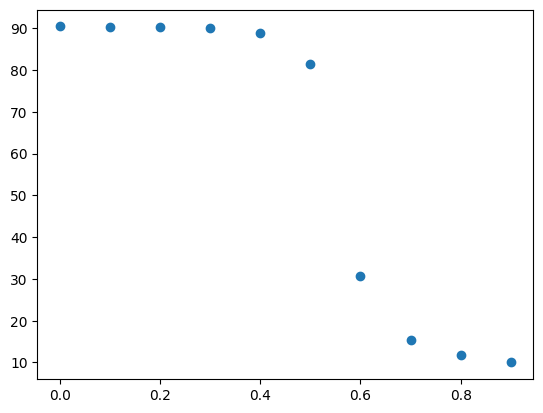

In [97]:
x = [r[0] for r in res]
y = [r[1] for r in res]
plt.scatter([*prune_amounts[:-1], 0], y)

In [235]:

def zero_out_pruned_filters(model, prune_ratio):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):  
            weight = module.weight.data
            if weight is None:
                continue

            if hasattr(module, '_pruned_filters'):
                pruned_filters = module._pruned_filters
            else:
                pruned_filters = []

            remaining_filters = set(range(weight.shape[0])) - set(pruned_filters)
            if not remaining_filters:
                continue
            remaining_filters = list(remaining_filters)
            filter_norms = weight[remaining_filters].abs().sum(dim=(1, 2, 3) if isinstance(module, nn.Conv2d) else (1,))

            _, sorted_indices = torch.sort(filter_norms)

            num_filters_to_prune = int(prune_ratio * len(remaining_filters))

            filters_to_zero = sorted_indices[:num_filters_to_prune]
            filters_to_zero = [remaining_filters[idx] for idx in filters_to_zero]
            weight[filters_to_zero] = 0
            module._pruned_filters = pruned_filters + filters_to_zero
            
    return model

In [ ]:
acc = 100.
n_epochs = 30
prune_ratios = [0.2, 0.3, 0.4]

train_transforms = get_best_transformations()
train_loader, val_loader = get_cifar10_train_val_loaders(transform=train_transforms)
test_loader = get_test_cifar10_dataloader()

model, _ = load_trained_model()
train_details = load_untrained_model("DenseNet121")

res = {}
for prune_ratio in prune_ratios:

    pruning_model = deepcopy(model)

    prune_track = []

    while acc > 85:
        pruning_model = zero_out_pruned_filters(pruning_model, prune_ratio=prune_ratio)
        params = count_nonzero_parameters(model)

        _, _, _ = run_epochs(
            pruning_model,
            train_loader,
            val_loader,
            train_details,
            n_epochs=n_epochs,
        )

        acc, _ = test(
            test_loader,
            pruning_model,
        )

        prune_track.append(
            (params, acc)
        )

    res[prune_ratio] = prune_track


613590

In [ ]:
 # Zero out 30% of filters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.optim as optim
from models import VGG







# === Pruning Methods ===

# 1. Global Pruning, no retrain
## CAUE - There is nothing special here, just applying the pruning function to the model


# 2. Global Pruning + Retrain
## CAUE - The same as the previous one, but retraining the model after the pruning
def method2_global_pruning_with_retrain(model, trainloader, testloader):
    print("\n=== Method 2: Global Pruning with Retrain ===")

    apply_global_pruning(model, amount=0.3)

    acc, _, _ = run_epochs(
        model,
        train_loader=trainloader,
        test_loader=testloader,
        hyperparams=HYPERPARAMS,
        n_epochs=1,
    )

    params = count_nonzero_parameters(model)
    print(f"Accuracy after retrain: {acc:.2f}% | Parameters: {params}")

    remove_pruning(model)

# 3. Gradual Pruning por etapas + Retrain
## CAUE - What I understood from this one was that we apply the pruning many times (steps)
## It is possible to change the pruning ratio in each step if we want
def method3_gradual_pruning(model, trainloader, testloader):
    print("\n=== Method 3: Gradual Pruning + Retrain ===")
    
    total_steps = 3
    pruning_amount_per_step = 0.1

    for step in range(total_steps):
        print(f"\n-- Step {step+1}/{total_steps} --")
        apply_global_pruning(model, amount=pruning_amount_per_step)

        acc, _, _ = run_epochs(
            model,
            train_loader=trainloader,
            test_loader=testloader,
            hyperparams=HYPERPARAMS,
            n_epochs=1, 
        )

        params = count_nonzero_parameters(model)
        print(f"Accuracy: {acc:.2f}% | Parameters: {params}")

    remove_pruning(model)

# 4. ThiNet
## CAUE - This one I've looked up and I found an article that describes the state of art
## The article can be found in here: https://arxiv.org/abs/1707.06342
## As far what I've read, it uses the L2 norm to discard the whole filter if it is considered not important
## and not the individual weight like how we have been doing
def method4_thinet_style_pruning(model, trainloader, testloader):
    print("\n=== Method 4: ThiNet Style Pruning ===")
    
    def prune_by_feature_map_norm(model, amount=0.3):
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                weight = module.weight.detach()
                filter_norms = weight.view(weight.size(0), -1).norm(2, dim=1)
                num_filters_to_prune = int(amount * weight.size(0))
                prune_idx = filter_norms.argsort()[:num_filters_to_prune]

                mask = torch.ones(weight.size(0), device=weight.device)
                mask[prune_idx] = 0

                mask = mask[:, None, None, None]
                module.weight.data.mul_(mask)

    prune_by_feature_map_norm(model, amount=0.3)

    acc, _, _ = run_epochs(
        model,
        train_loader=trainloader,
        test_loader=testloader,
        hyperparams=HYPERPARAMS,
        n_epochs=1,
    )

    params = count_nonzero_parameters(model)
    print(f"Accuracy after ThiNet pruning + retrain: {acc:.2f}% | Parameters: {params}")

In [ ]:
model = VGG("VGG19").to(device)
trainloader = get_train_cifar10_dataloader()
testloader = get_test_cifar10_dataloader()

## CAUE - I used your function to get the hyperparameters, but I changed the way the optimiser was defined
## because the pickle returns it as a string
HYPERPARAMS = get_hyperparams()
HYPERPARAMS["criterion"] = nn.CrossEntropyLoss()
HYPERPARAMS["optimiser"] = optim.AdamW(model.parameters(), lr=HYPERPARAMS['lr'], weight_decay=HYPERPARAMS['weight_decay'])

acc_before, _ = test(testloader, model)
print(f"Accuracy before pruning: {acc_before:.2f}%")

method1_global_pruning_no_retrain(model, trainloader, testloader)
method2_global_pruning_with_retrain(model, trainloader, testloader)
method3_gradual_pruning(model, trainloader, testloader)
#method4_thinet_style_pruning(model, trainloader, testloader)

Accuracy before pruning: 10.00%

=== Method 1: Global Pruning without Retrain ===
Accuracy: 10.00% | Parameters: 20035016

=== Method 2: Global Pruning with Retrain ===
Epoch: 0
Saving..
Accuracy after retrain: 58.93% | Parameters: 14033322

=== Method 3: Gradual Pruning + Retrain ===

-- Step 1/3 --
Epoch: 0
Saving..
Accuracy: 71.93% | Parameters: 17954449

-- Step 2/3 --
Epoch: 0
Saving..
Accuracy: 74.17% | Parameters: 17954449

-- Step 3/3 --
Epoch: 0
Saving..
Accuracy: 80.17% | Parameters: 17954449

=== Method 4: ThiNet Style Pruning ===


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [45]:
method4_thinet_style_pruning(model, trainloader, testloader)


=== Method 4: ThiNet Style Pruning ===
Epoch: 0
Saving..
Accuracy after ThiNet pruning + retrain: 79.81% | Parameters: 20019550


In [ ]:
## CAUE - At some point I had to use this because I got a OutOfMemoryError when running the models
import gc
gc.collect()

25671